In [ ]:
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import metrics
import tensorflow as tf
import time
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Input

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_dataset, info = tfds.load('shapes3d', split='train[:1%]', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/480000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/shapes3d/2.0.0.incomplete55CYLV/shapes3d-train.tfrecord*...:   0%|        …

Dataset shapes3d downloaded and prepared to /root/tensorflow_datasets/shapes3d/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Unfortunately, I was only able to run the program for 1% of the data, I tried 10% and each epoch was going over 40mins
# So I had to cut it to 1%

In [ ]:
info

tfds.core.DatasetInfo(
    name='shapes3d',
    full_name='shapes3d/2.0.0',
    description="""
    3dshapes is a dataset of 3D shapes procedurally generated from 6 ground truth
    independent latent factors. These factors are *floor colour*, *wall colour*,
    *object colour*, *scale*, *shape* and *orientation*.
    
    All possible combinations of these latents are present exactly once, generating
    N = 480000 total images.
    
    ### Latent factor values
    
    *   floor hue: 10 values linearly spaced in [0, 1]
    *   wall hue: 10 values linearly spaced in [0, 1]
    *   object hue: 10 values linearly spaced in [0, 1]
    *   scale: 8 values linearly spaced in [0, 1]
    *   shape: 4 values in [0, 1, 2, 3]
    *   orientation: 15 values linearly spaced in [-30, 30]
    
    We varied one latent at a time (starting from orientation, then shape, etc), and
    sequentially stored the images in fixed order in the `images` array. The
    corresponding values of the factors are s

In [ ]:
# First we will standarize the images, we will rescale them between [0, 1]

rescaled_images = []
for tensor in list(train_dataset.take(len(train_dataset))): # For each of the images in the dataset
  rescaled_images.append(layers.Rescaling(1./255)(tensor['image'])) # Rescale the image

In [ ]:
class CVAE(tf.keras.Model):
  # The constructor recieves an encoder, decoder and the latent dimension as the input
  def __init__(self, latent_dim, encoder, decoder, **kwargs):
    super(CVAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.latent_dim = latent_dim # The latent dim is 2 which is the mean and var of the distribution
    self.optimizer = optimizer = tf.keras.optimizers.Adam(1e-4)

    # The model's metrics
    self.total_loss_tracker = metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
      return [
          self.total_loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
          ]


  def train_step(self, data):
    """This function calls the encode and decode function, computes the losses and optimizes encode and decode models"""
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encode(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }

  def train(self):
    """This function runs the self.train_step function for each of the training images, for the number of epochs and prints the results"""
    epochs = 12
    train_result = None

    for epoch in range(epochs):
      start_time = time.time()
      for train_x in rescaled_images: # Each image
        single_image = np.expand_dims(train_x, axis=0)
        train_result = self.train_step(single_image) # Train
      end_time = time.time()
      print('Epoch: {}, loss: {}, reconstruction_loss: {}, kl_loss: {}, time elapse for current epoch: {}'
            .format(epoch+1, train_result['loss'],
                    train_result['reconstruction_loss'], train_result['kl_loss'], end_time - start_time))

  def decode(self, z):
    """This function calls the decoder model and returns the generated image"""
    logits = self.decoder(z)
    return logits


  def encode(self, x):
    """This function calls the encoder model which returns mean and var distributions.
    This function will return the mean, var and their normal distribution that represents the images"""
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    eps = tf.random.normal(shape=mean.shape)
    return mean, logvar, eps * tf.exp(logvar * .5) + mean # Normal distribution


  def plot_latent_images(self, n=20, digit_size=64):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n # Size of the image which is the same as the length and width of the image
    image_height = image_width
    image = np.zeros((image_height, image_width, 3))

    for i, yi in enumerate(grid_x):
      for j, xi in enumerate(grid_y):
        z = np.array([[xi, yi]])
        x_decoded = self.decode(z)
        digit = tf.reshape(x_decoded[0], (digit_size, digit_size, 3))

        image[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size, :] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('Off')
    plt.show()

In [ ]:
latent_dim = 2
image_shape = (64, 64, 3)

encoder_model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=image_shape), # input is the shape of the image
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(
            filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(latent_dim + latent_dim),
    ])

decoder_model = tf.keras.Sequential( # The output is the same size as the images
    [
        tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
        tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu),
        tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
        tf.keras.layers.Conv2DTranspose(
            filters=128, kernel_size=3, strides=2, padding='same',
            activation='relu'),
        tf.keras.layers.Conv2DTranspose(
            filters=64, kernel_size=3, strides=2, padding='same',
            activation='relu'),
        tf.keras.layers.Conv2DTranspose(
            filters=3, kernel_size=3, strides=1, padding='same'),
    ])

In [ ]:
encoder_model.summary() # This confirms that the encoder model has the output size of 4

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 31, 31, 64)        1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 flatten_2 (Flatten)         (None, 28800)             0         
                                                                 
 dense_4 (Dense)             (None, 4)                 115204    
                                                                 
Total params: 190,852
Trainable params: 190,852
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder_model.summary() # This confirms that the decoder model has the output size of ((64, 64, 3))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8192)              24576     
                                                                 
 reshape_2 (Reshape)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 32, 32, 128)      36992     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 64, 64, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 64, 64, 3)        1731      
 ranspose)                                                       
                                                      

In [ ]:
cvae = CVAE(latent_dim, encoder_model, decoder_model)

In [ ]:
cvae.train()

Epoch: 1, loss: 2779.3037109375, reconstruction_loss: 2739.67138671875, kl_loss: 39.6287956237793, time elapse for current epoch: 184.16386651992798
Epoch: 2, loss: 2585.24951171875, reconstruction_loss: 2559.80615234375, kl_loss: 25.446918487548828, time elapse for current epoch: 183.1847836971283
Epoch: 3, loss: 2487.94580078125, reconstruction_loss: 2467.7109375, kl_loss: 20.247037887573242, time elapse for current epoch: 183.09185433387756
Epoch: 4, loss: 2432.51220703125, reconstruction_loss: 2415.3232421875, kl_loss: 17.19662857055664, time elapse for current epoch: 183.10806965827942
Epoch: 5, loss: 2365.48388671875, reconstruction_loss: 2350.273193359375, kl_loss: 15.219148635864258, time elapse for current epoch: 183.36116433143616
Epoch: 6, loss: 2307.560791015625, reconstruction_loss: 2293.60009765625, kl_loss: 13.964385986328125, time elapse for current epoch: 182.6376872062683
Epoch: 7, loss: 2259.222412109375, reconstruction_loss: 2246.155029296875, kl_loss: 13.0663537979

In [ ]:
# We can see that the loss is decreasing in each epoch

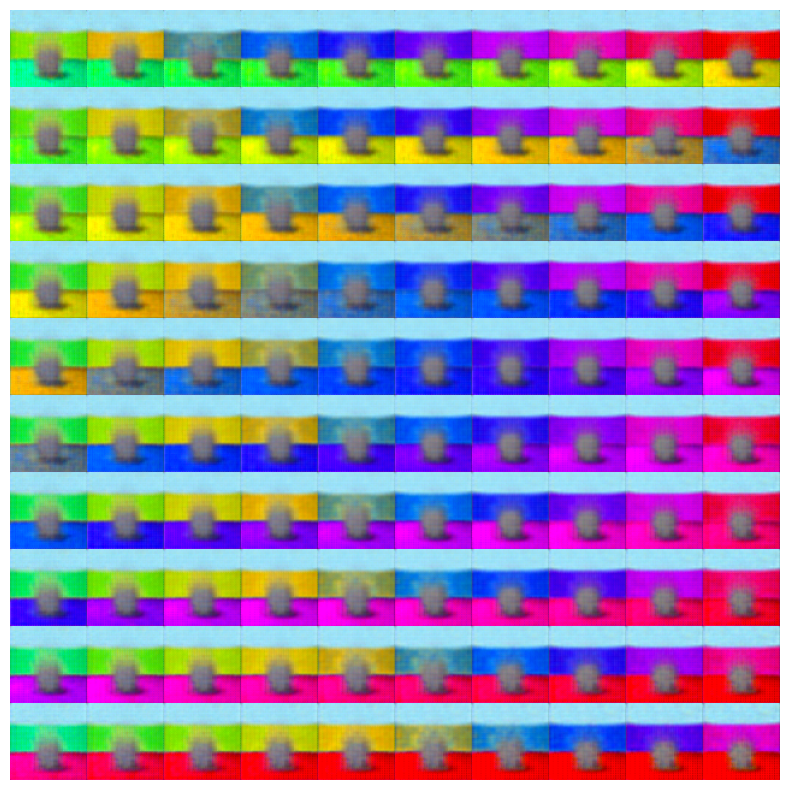

In [ ]:
cvae.plot_latent_images(n=10)